In [1]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=2 #Number of classes for segmentation

In [2]:
import os

# Get the list of image file paths
image_paths = glob.glob('/kaggle/input/blood-cell-segmentation/images/*png')

# Sort the image file paths based on their names
image_paths.sort()  # Sorts in lexicographical order by default, which should sort by filename

# Initialize an empty list to store the loaded images
train_images = []

# Iterate over the sorted list of image file paths
for img_path in image_paths:
    # Load and preprocess each image
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_images.append(img)
#Convert list to array for machine learning processing
train_images = np.array(train_images)

In [3]:
import os

# Get the list of mask file paths
mask_paths = glob.glob('/kaggle/input/blood-cell-segmentation/Mask/*png')

# Sort the mask file paths based on their names
mask_paths.sort()  # Sorts in lexicographical order by default, which should sort by filename

# Alternatively, you can sort based on other criteria, such as modification time:
# mask_paths.sort(key=os.path.getmtime)

# Initialize an empty list to store the loaded masks
train_masks = []

# Iterate over the sorted list of mask file paths
for mask_path in mask_paths:
    # Load and preprocess each mask
    mask = cv2.imread(mask_path, 1)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Ensure nearest-neighbor interpolation for masks
    train_masks.append(mask)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
print(len(train_images))
print(len(train_masks))

1323
1323


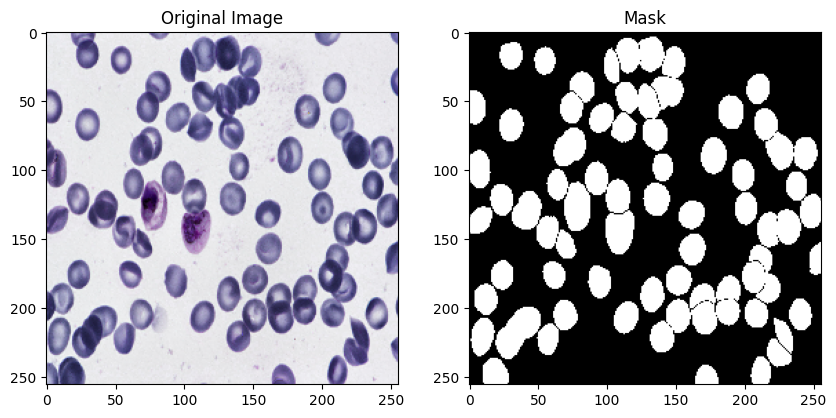

In [5]:
import random

# Select a random index to display image and mask
random_idx = random.randint(0, len(train_images) - 1)

# Original image
image = train_images[random_idx]

# Corresponding mask
mask = train_masks[random_idx]

# Plotting the image and the mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))  # Display the mask in grayscale
plt.title('Mask')

plt.show()

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming train_masks has the shape (n, h, w, 3)
n, h, w, c = train_masks.shape  # c = 3 for RGB masks

# Flatten the mask for processing
train_masks_reshaped = train_masks.reshape(-1, c)  # Flatten the RGB masks

# Create a LabelEncoder
labelencoder = LabelEncoder()

# Convert each RGB triplet to a single string (or tuple) for encoding
train_masks_reshaped_as_str = np.array([str(tuple(rgb)) for rgb in train_masks_reshaped])

# Fit and transform the LabelEncoder on the RGB tuples
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped_as_str)

# Reshape the encoded masks back to the original shape (n, h, w)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# Check unique values (i.e., class labels)
print(np.unique(train_masks_encoded_original_shape))

# Expand dimensions for the model input
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

[0 1]


In [7]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1]


In [8]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [9]:
################################################################
def multi_unet_model(n_classes=2, IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [10]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [11]:
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from keras.metrics import binary_accuracy



import tensorflow as tf

def focal_loss(y_true, y_pred, gamma=2.0):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)

#     if class_weights is not None:
#         # Retrieve class weights based on the true labels
#         weights = tf.reduce_sum(class_weights * y_true, axis=-1)
#         cross_entropy *= weights

    loss = tf.pow(1 - y_pred, gamma) * cross_entropy
    return tf.reduce_mean(loss, axis=-1)



def soft_dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    sum_true = tf.reduce_sum(y_true, axis=(1, 2, 3))
    sum_pred = tf.reduce_sum(y_pred, axis=(1, 2, 3))
    dice_coefficient = (2. * intersection + smooth) / (sum_true + sum_pred + smooth)
    return tf.reduce_mean(dice_coefficient)


def soft_dice_loss(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    sum_true = tf.reduce_sum(y_true, axis=(1, 2, 3))
    sum_pred = tf.reduce_sum(y_pred, axis=(1, 2, 3))
    dice_coefficient = (2. * intersection + smooth) / (sum_true + sum_pred + smooth)
    dice_loss = 1 - dice_coefficient
    return tf.reduce_mean(dice_loss)



def combined_loss(y_true, y_pred, gamma=2.0, alpha=0.5):
    focal = focal_loss(y_true, y_pred, gamma)
    dice = soft_dice_loss(y_true, y_pred)
    return alpha * focal + (1 - alpha) * dice


# import tensorflow as tf
# from keras.metrics import MeanIoU

# # Create MeanIoU object outside the function
# n_classes = 4
# #IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras = MeanIoU(num_classes=n_classes, name='mean_iou')

# @tf.function
# def mean_iou(y_true, y_pred):
#     # Update the state of IOU_keras inside the function
#     IOU_keras.update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
#     return IOU_keras.result()

import tensorflow as tf


class CustomMeanIoU(tf.keras.metrics.MeanIoU):
   
    def __init__(self, num_classes=None, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.math.argmax(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
custom_mIoU_metric = CustomMeanIoU(num_classes=4, name='mean_iou')

In [12]:
model = get_model()
# Compile the model with Focal Loss and both Accuracy and Dice Coefficient as metrics
#model.compile(optimizer=Adam(), loss=combined_loss, metrics=['accuracy', soft_dice_coefficient])
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['accuracy', soft_dice_coefficient, custom_mIoU_metric])

# Print model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 8,037,298 (30.66 MB)

 Trainable params: 8,033,810 (30.65 MB)

 Non-trainable params: 3,488 (13.62 KB)

In [13]:
# Define Early Stopping to monitor 'val_dice_coefficient' and restore the best weights
early_stopping = EarlyStopping(monitor='val_mean_iou', patience=100, mode='max', restore_best_weights=True)

# Define Model Checkpoint to save the best model based on 'val_dice_coefficient'
model_checkpoint = ModelCheckpoint('saved_model1_t2_resized_v2_Kaggle_200eo_gamma_2_alpha_0.5_B8_MODEL_SAN.keras', monitor='val_mean_iou', mode='max', save_best_only=True)

# Train the model with Early Stopping and Model Checkpoint
history = model.fit(X_train, y_train_cat,
                    batch_size=8,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test_cat),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle=False)

Epoch 1/100


I0000 00:00:1725981504.553138     112 service.cc:145] XLA service 0x78150c005490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725981504.553199     112 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725981504.553205     112 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-09-10 15:18:47.308401: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[8,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,128,128]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-10 15:18:47.886655: E external/local_xla

  1/149 ━━━━━━━━━━━━━━━━━━━━ 2:09:47 53s/step - accuracy: 0.5553 - loss: 0.3315 - mean_iou: 0.3271 - soft_dice_coefficient: 0.5183

I0000 00:00:1725981546.213509     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/149 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9224 - loss: 0.0788 - mean_iou: 0.8115 - soft_dice_coefficient: 0.8892

2024-09-10 15:19:42.402310: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[6,96,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,128,128]{3,2,1,0}, f32[64,96,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-10 15:19:42.809193: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.406976498s
Trying algorithm eng4{k11=1} for conv (f32[6,96,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,64,128,128]{3,2,1,0}, f32[64,96,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

149/149 ━━━━━━━━━━━━━━━━━━━━ 121s 460ms/step - accuracy: 0.9228 - loss: 0.0785 - mean_iou: 0.8115 - soft_dice_coefficient: 0.8897 - val_accuracy: 0.9551 - val_loss: 0.0819 - val_mean_iou: 0.9001 - val_soft_dice_coefficient: 0.8588
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9662 - loss: 0.0360 - mean_iou: 0.9052 - soft_dice_coefficient: 0.9523 - val_accuracy: 0.9628 - val_loss: 0.0506 - val_mean_iou: 0.9177 - val_soft_dice_coefficient: 0.9170
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.9720 - loss: 0.0299 - mean_iou: 0.9199 - soft_dice_coefficient: 0.9606 - val_accuracy: 0.9624 - val_loss: 0.0437 - val_mean_iou: 0.9168 - val_soft_dice_coefficient: 0.9335
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - accuracy: 0.9745 - loss: 0.0272 - mean_iou: 0.9265 - soft_dice_coefficient: 0.9643 - val_accuracy: 0.9703 - val_loss: 0.0316 - val_mean_iou: 0.9328 - val_soft_dice_coefficient: 0.9554
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 21

In [49]:
# Save the trained model in HDF5 format
model.save('Blood Cell Segmentation in color 2/5.hdf5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


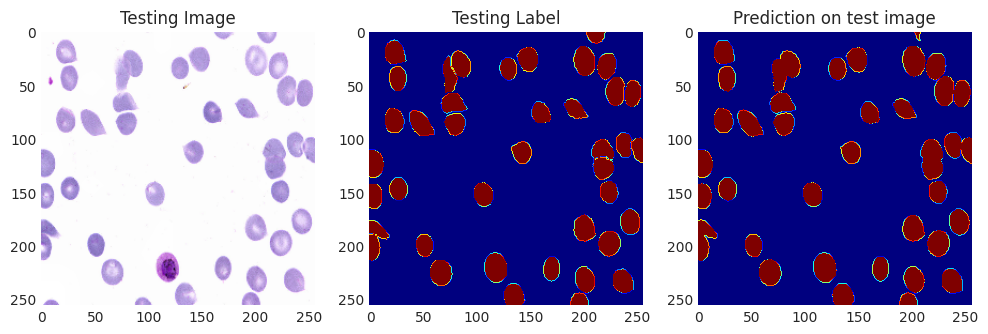

In [44]:
import random
import matplotlib.pyplot as plt
import cv2

# Select a random test image
test_img_number = random.randint(0, len(X_test) - 1)  # Correct range
test_img = X_test[test_img_number]  # Original image (likely in BGR)
ground_truth = y_test[test_img_number]

# Convert the test image from BGR to RGB for proper display
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Make prediction
prediction = model.predict(np.expand_dims(test_img, axis=0))
predicted_img = np.argmax(prediction, axis=-1)[0]  # Assuming channel dimension is the last axis

# Plotting
plt.figure(figsize=(12, 8))

# Display the original RGB test image
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_rgb)  # Displaying the original image converted to RGB
plt.grid(False)  # Remove grid

# Display the ground truth mask
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')  # Using 'jet' colormap for mask
plt.grid(False)  # Remove grid

# Display the predicted mask
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')  # Using 'jet' colormap for prediction
plt.grid(False)  # Remove grid

plt.show()


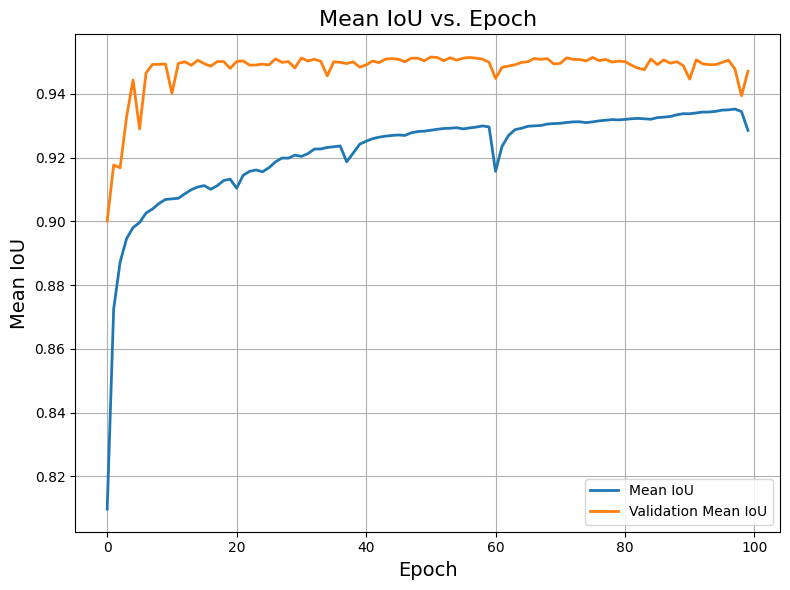

In [15]:
# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_iou'], label='Mean IoU', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean IoU', fontsize=14)
plt.title('Mean IoU vs. Epoch', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Calculate IoU for each class
iou_classes = []
for i in range(n_classes):
    intersection = np.sum((y_test[:,:,:,0] == i) & (y_pred_argmax == i))
    union = np.sum((y_test[:,:,:,0] == i) | (y_pred_argmax == i))
    if union == 0:
        iou = 1.0  # If there are no ground truth or predicted pixels for this class, set IoU to 1 (by definition)
    else:
        iou = intersection / union
    iou_classes.append(iou)

class_iou = dict(zip(range(n_classes), iou_classes))
print("IoU for each class:", class_iou)

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step
Mean IoU = 0.9515685
IoU for each class: {0: 0.9703368143355354, 1: 0.9328001168291598}


In [17]:
# Evaluate the model on the test data
evaluation_results = model.evaluate(X_test, y_test_cat)

# Unpack the evaluation results
loss = evaluation_results[0]
accuracy = evaluation_results[1]
dice_coefficient = evaluation_results[2]

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Dice Coefficient:", dice_coefficient)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9796 - loss: 0.0244 - mean_iou: 0.9527 - soft_dice_coefficient: 0.9716
Loss: 0.024881234392523766
Accuracy: 0.9789884090423584
Dice Coefficient: 0.9694045186042786


/tmp/ipykernel_36/2063386466.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


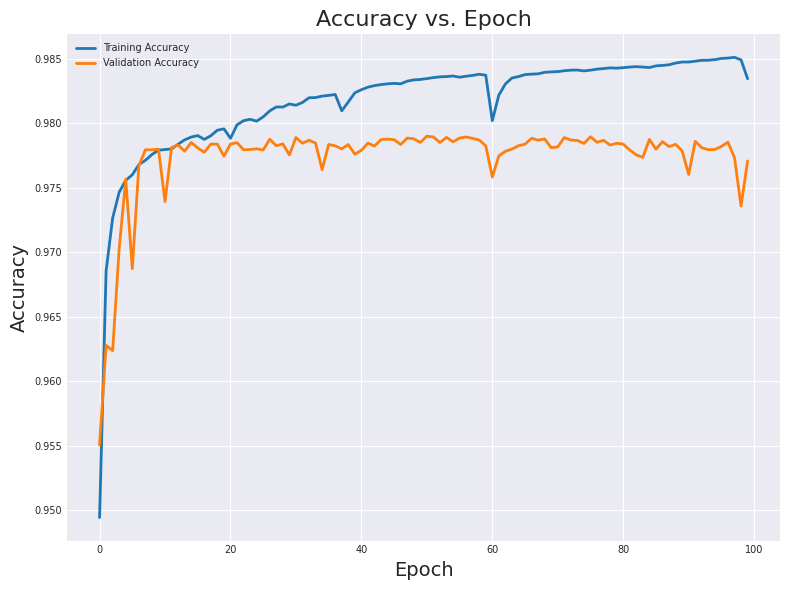

In [18]:
import matplotlib.pyplot as plt

# Set custom style
plt.style.use('seaborn-darkgrid')

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Epoch', fontsize=16)
plt.legend(fontsize=7)
plt.grid(True)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)  # Decrease font size for y-axis ticks
plt.locator_params(axis='y', nbins=10)  # Set the number of ticks on the y-axis
plt.tight_layout()
plt.show()

/tmp/ipykernel_36/1187145432.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


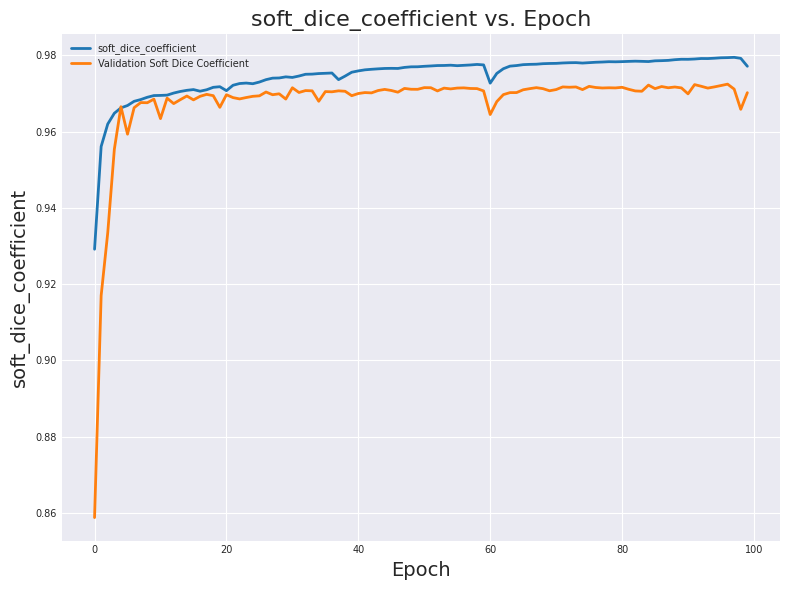

In [19]:
import matplotlib.pyplot as plt



# Set custom style
plt.style.use('seaborn-darkgrid')

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['soft_dice_coefficient'], label='soft_dice_coefficient', linewidth=2)
plt.plot(history.history['val_soft_dice_coefficient'], label='Validation Soft Dice Coefficient', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('soft_dice_coefficient', fontsize=14)
plt.title('soft_dice_coefficient vs. Epoch', fontsize=16)
plt.legend(fontsize=7)
plt.grid(True)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)  # Decrease font size for y-axis ticks
plt.locator_params(axis='y', nbins=10)  # Set the number of ticks on the y-axis
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import tensorflow as tf

# Define dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Extract y_true and y_pred from your model training
# Assuming your model is named 'model' and you have a validation dataset (X_test, y_test_cat)
# Predict on validation data
y_pred = model.predict(X_test)

# Assuming y_test_cat is the ground truth segmentation masks
y_true = y_test_cat
# Cast y_pred to the same data type as y_true (float64)
y_pred = tf.cast(y_pred, dtype=tf.float64)

# Function to calculate mean Dice coefficient for each class
def mean_dice_per_class(y_true, y_pred, num_classes, smooth=1):
    mean_dice_per_class = []
    for class_idx in range(num_classes):
        class_true = y_true[..., class_idx]
        class_pred = y_pred[..., class_idx]
        dice = dice_coefficient(class_true, class_pred, smooth)
        mean_dice_per_class.append(dice)
    return mean_dice_per_class

# Example usage:
# Define the number of classes (assuming it's known)
n_classes = 2  # Adjust this value according to your dataset

# Calculate mean Dice coefficient for each class
mean_dice_per_class_values = mean_dice_per_class(y_true, y_pred, n_classes)

# Print mean Dice coefficient for each class
for class_idx, dice_value in enumerate(mean_dice_per_class_values):
    print(f"Mean Dice coefficient for class {class_idx}: {dice_value.numpy()}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Mean Dice coefficient for class 0: 0.979861960112724
Mean Dice coefficient for class 1: 0.953205201725122


In [21]:
from sklearn.metrics import confusion_matrix

# Predict on the test dataset
y_pred = model.predict(X_test)

# Convert predicted masks and ground truth masks to categorical labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test_cat, axis=-1)

# Flatten both predicted and ground truth labels
y_pred_labels_flat = y_pred_labels.flatten()
y_true_labels_flat = y_true_labels.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels_flat, y_pred_labels_flat)

print("Confusion Matrix:")
print(conf_matrix)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Confusion Matrix:
[[5990941  103497]
 [  79646 2542204]]


In [22]:
def calculate_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score

precision, recall, f1_score = calculate_metrics(conf_matrix)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: [0.98688002 0.96088107]
Recall: [0.98301779 0.96962221]
F1 Score: [0.98494512 0.96523185]


In [23]:
import numpy as np

def calculate_metrics(conf_matrix):
    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP

    # Calculate Precision
    precision = TP / (TP + FP)

    # Calculate Recall (Sensitivity or True Positive Rate)
    recall = TP / (TP + FN)

    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Calculate average precision, recall, and F1 score
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1_score = np.mean(f1_score)

    return avg_precision, avg_recall, avg_f1_score


# Call the function to calculate metrics
avg_precision, avg_recall, avg_f1_score = calculate_metrics(conf_matrix)

print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1_score)

Precision: 0.9738805418847175
Recall: 0.9763200037901516
F1 Score: 0.9750884849668974


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


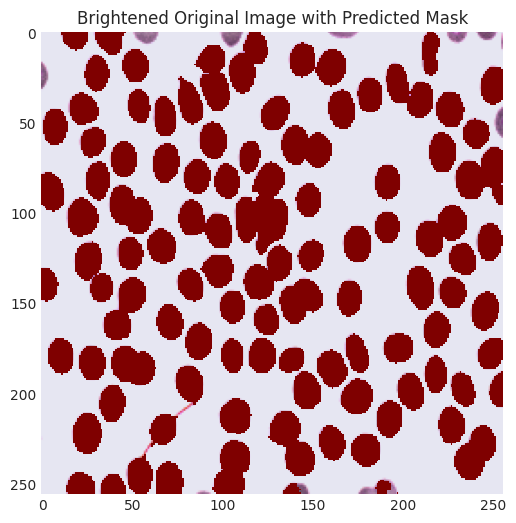

In [48]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Define the threshold
threshold = 0.2

# Select a random test image
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]  # RGB image
test_img_norm = test_img / 255.0  # Normalize the RGB image to [0, 1]

# Increase brightness by scaling pixel values
brightness_factor = 1.5  # Adjust this factor to increase or decrease brightness
brightened_img = np.clip(test_img_norm * brightness_factor, 0, 1)  # Apply brightness factor and clip to [0, 1] range

# Make prediction
prediction = model.predict(np.expand_dims(test_img, axis=0))
predicted_probabilities = prediction[0]  # Assuming channel dimension is the last axis

# Apply threshold
predicted_mask = np.argmax(predicted_probabilities, axis=-1)
predicted_mask[predicted_probabilities.max(axis=-1) < threshold] = 0  # Assuming background class index is 0

# Define transparency levels for each class
alpha_values = np.ones_like(predicted_mask, dtype=np.float32)

# Set transparency for background class
alpha_values[predicted_mask == 0] = 0.1

# Set transparency for other classes
alpha_values[(predicted_mask != 0) & (predicted_mask != 1)] = 0.8  # Adjust alpha for other classes as desired

# Plotting
plt.figure(figsize=(8, 6))

# Overlay the brightened original RGB image and the predicted mask with transparency
plt.imshow(brightened_img)  # Show the brightened RGB image
plt.imshow(predicted_mask, cmap='jet', alpha=alpha_values, interpolation='nearest')  # Overlay the predicted mask with transparency
plt.title('Brightened Original Image with Predicted Mask')
plt.grid(False)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


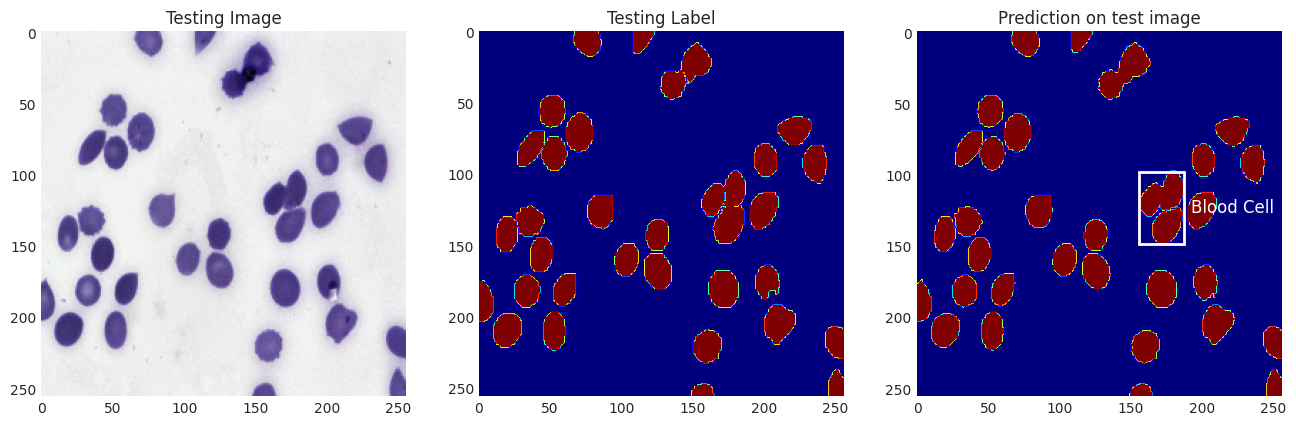

In [52]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2  # Ensure OpenCV is imported for contour finding

# Define the threshold
threshold = 0.2

# Select a random test image
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]  # Use the RGB image here
ground_truth = y_test[test_img_number]

# Make prediction
prediction = model.predict(np.expand_dims(test_img, axis=0))
predicted_img = np.argmax(prediction, axis=-1)[0]  # Assuming channel dimension is the last axis

# Define class names
class_names = ['Background', 'Blood Cell']

# Plotting
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')

# Display the original RGB image instead of grayscale
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # Ensure the image is in RGB format
plt.grid(False)  # Remove grid

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet', extent=(0, ground_truth.shape[1], ground_truth.shape[0], 0))  # Set extent to match the size of the image
plt.grid(False)  # Remove grid

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.grid(False)  # Remove grid

# Add bounding boxes with class names for non-background classes
for class_index in range(1, len(class_names)):
    # Find contours for each class
    contours, _ = cv2.findContours(np.uint8(ground_truth[:, :, 0] == class_index), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:  # Check if there are contours for the class
        contour = max(contours, key=cv2.contourArea)  # Get the largest contour
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        # Draw bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='white', facecolor='none')  # Change edgecolor here
        plt.gca().add_patch(rect)
        # Add class name
        class_name = class_names[class_index]
        # Position the text to the right of the bounding box
        text_x = x + w + 5  # Adjust the offset as needed
        text_y = y + h // 2  # Position at the center of the bounding box
        plt.text(text_x, text_y, class_name, color='white', fontsize=12, verticalalignment='center')

plt.grid(False)  # Remove grid
plt.show()
